In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/densenet_67acc_2/tensorflow2/default/1/model_67_2.keras
/kaggle/input/densenet/tensorflow2/default/1/model_60_1.keras
/kaggle/input/vgg-face-test-train/test/test/n000463/0085_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0030_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0014_02.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0052_02.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0038_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0099_02.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0087_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0056_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0019_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0005_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0023_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0039_01.jpg
/kaggle/input/vgg-face-test-train/test/test/n000463/0001_01.jpg
/kaggle/input/vgg-face-test-train/te

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.applications import InceptionV3
# import Early Stopping/Callbacks
from tensorflow.keras.callbacks import EarlyStopping
# import Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data="/kaggle/input/vgg-face-test-train/train_2/train_2"
test="/kaggle/input/vgg-face-test-train/test/test"

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation for training and rescaling for validation
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=40,       # Random rotations up to 40 degrees
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest',     # Fill empty pixels after transformations
    validation_split=0.2     # Split data into training and validation
)

# Training generator
train_generator = datagen.flow_from_directory(
    data,                    # Path to your image dataset
    target_size=(299, 299),  # Resize images for Xception model input
    batch_size=32,
    class_mode='categorical', # Multi-class classification
    subset='training'        # Use the training subset
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    data,                    # Same dataset path
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'      # Use the validation subset
)


Found 8841 images belonging to 40 classes.
Found 2188 images belonging to 40 classes.


In [5]:
testagen = ImageDataGenerator(rescale=1./255)

test_generator = testagen.flow_from_directory(
    test, 
    target_size=(299, 299),             
    batch_size=16,                      
    class_mode='categorical',                     
    shuffle=False                        
)

Found 5180 images belonging to 40 classes.


In [6]:
# Display some information about the dataset
print("Dataset Information:")
print(f'Training samples: {train_generator.samples}')
print(f'Validation samples: {validation_generator.samples}')
print(f'Class indices: {train_generator.class_indices}')

Dataset Information:
Training samples: 8841
Validation samples: 2188
Class indices: {'n000059': 0, 'n000070': 1, 'n000083': 2, 'n000425': 3, 'n000462': 4, 'n000463': 5, 'n000464': 6, 'n000465': 7, 'n000466': 8, 'n000467': 9, 'n000468': 10, 'n000469': 11, 'n000471': 12, 'n000472': 13, 'n000473': 14, 'n000474': 15, 'n000475': 16, 'n000476': 17, 'n000477': 18, 'n000478': 19, 'n000479': 20, 'n000481': 21, 'n000482': 22, 'n000483': 23, 'n000484': 24, 'n000485': 25, 'n000487': 26, 'n000488': 27, 'n000489': 28, 'n000490': 29, 'n000491': 30, 'n000492': 31, 'n000494': 32, 'n000495': 33, 'n000496': 34, 'n000497': 35, 'n000498': 36, 'n000500': 37, 'n000501': 38, 'n000502': 39}


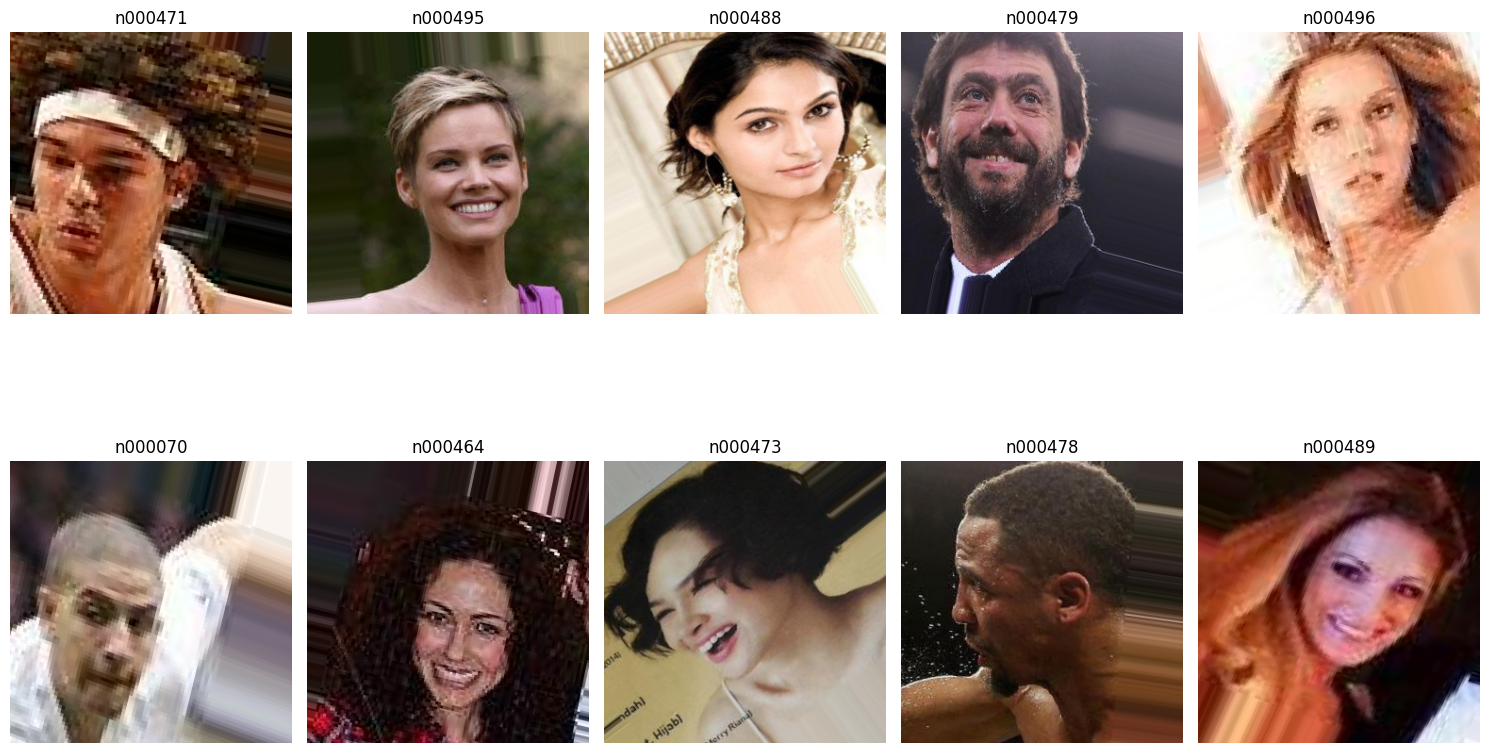

In [7]:
# Retrieve a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Track displayed classes
displayed_classes = set()

# Display images, ensuring one per class
plt.figure(figsize=(15, 10))  # Adjust size for up to 10 images
images_shown = 0  # Counter for displayed images
for i in range(len(batch_images)):
    # Get the class label
    label = list(train_generator.class_indices.keys())[np.argmax(batch_labels[i])]

    # Skip if this class is already displayed
    if label in displayed_classes:
        continue

    # Add the label to the displayed set
    displayed_classes.add(label)

    # Display the image
    ax = plt.subplot(2, 5, images_shown + 1)  # 2 rows, 5 columns
    plt.imshow(batch_images[i])
    plt.title(label)
    plt.axis("off")

    images_shown += 1
    if images_shown == 10:  # Stop after showing 10 images
        break

plt.tight_layout()
plt.show()


In [8]:
# Assuming you want to get the number of classes from your training generator:
num_classes = len(train_generator.class_indices)
num_classes

40

In [9]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2


# Load the DenseNet121 model with pretrained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers initially
base_model.trainable = False

# Unfreeze the last 10 layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
# Add custom layers for your classification task
model = models.Sequential([
    base_model,  # Pretrained DenseNet121 model
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(40, activation='softmax')  # 40 classes (adjust to your dataset)
])

# Pass a dummy input through the model to build it
_ = model(tf.zeros((1, 299, 299, 3)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (1, 9, 9, 1024)        │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 1024)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (1, 1024)              │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1024)              │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 1024)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 40)                │        41,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,132,200 (31.02 MB)

 Trainable params: 1,260,776 (4.81 MB)

 Non-trainable params: 6,871,424 (26.21 MB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint_path = '/kaggle/working/your_checkpoint_file.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# إنشاء Callback لإيقاف التدريب المبكر
early_stopping_callback = EarlyStopping(
    monitor='val_loss',     
    patience=5,              
    restore_best_weights=True    
)

In [11]:
from sklearn.utils import class_weight
import numpy as np

# حساب الأوزان
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.1571989528795812, 1: 0.9209375, 2: 0.9209375, 3: 0.8247201492537314, 4: 0.8247201492537314, 5: 1.0941831683168317, 6: 1.1452072538860103, 7: 0.8736166007905138, 8: 1.3477134146341463, 9: 1.1756648936170213, 10: 1.2702586206896551, 11: 0.8008152173913043, 12: 1.1452072538860103, 13: 0.5498134328358208, 14: 1.1276785714285715, 15: 1.0941831683168317, 16: 1.2558238636363637, 17: 0.9095679012345679, 18: 1.416826923076923, 19: 1.0677536231884057, 20: 0.9365466101694915, 21: 1.2077868852459017, 22: 0.837215909090909, 23: 1.0475118483412322, 24: 0.86337890625, 25: 0.8912298387096774, 26: 1.315625, 27: 1.0328271028037384, 28: 1.263, 29: 1.263, 30: 0.746706081081081, 31: 1.2144230769230768, 32: 0.8037272727272727, 33: 0.8876506024096386, 34: 1.7133720930232559, 35: 0.7674479166666667, 36: 0.9736784140969162, 37: 0.8008152173913043, 38: 1.1393041237113402, 39: 1.3559815950920246}


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50 ,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler,model_checkpoint_callback,early_stopping_callback]
)

Epoch 1/50


I0000 00:00:1734528985.843432     116 service.cc:145] XLA service 0x7cb824002440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734528985.843513     116 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734528985.843519     116 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/277 ━━━━━━━━━━━━━━━━━━━━ 2:59:33 39s/step - accuracy: 0.0000e+00 - loss: 3.9078

I0000 00:00:1734529006.460176     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


277/277 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.2268 - loss: 3.0854 - val_accuracy: 0.5402 - val_loss: 1.6380 - learning_rate: 0.0010
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 211s 746ms/step - accuracy: 0.5022 - loss: 1.8055 - val_accuracy: 0.6499 - val_loss: 1.2785 - learning_rate: 0.0010
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 209s 740ms/step - accuracy: 0.5937 - loss: 1.4488 - val_accuracy: 0.7171 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 209s 739ms/step - accuracy: 0.6418 - loss: 1.3187 - val_accuracy: 0.7399 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 209s 740ms/step - accuracy: 0.6925 - loss: 1.1407 - val_accuracy: 0.7742 - val_loss: 0.8815 - learning_rate: 0.0010
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 207s 734ms/step - accuracy: 0.7183 - loss: 1.0567 - val_accuracy: 0.7048 - val_loss: 1.1394 - learning_rate: 0.0010
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 209s 738ms/step - accuracy: 0.7282 - l

In [ ]:
# import tensorflow as tf
# print("GPU Available:", tf.config.list_physical_devices('GPU'))
#tf.config.optimizer.set_jit(True)

In [13]:
model.evaluate(test_generator)

324/324 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - accuracy: 0.9334 - loss: 0.3672


[0.42685189843177795, 0.9173744916915894]

In [14]:
model.evaluate(validation_generator)

69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 592ms/step - accuracy: 0.8803 - loss: 0.5229


[0.5311353206634521, 0.8770566582679749]

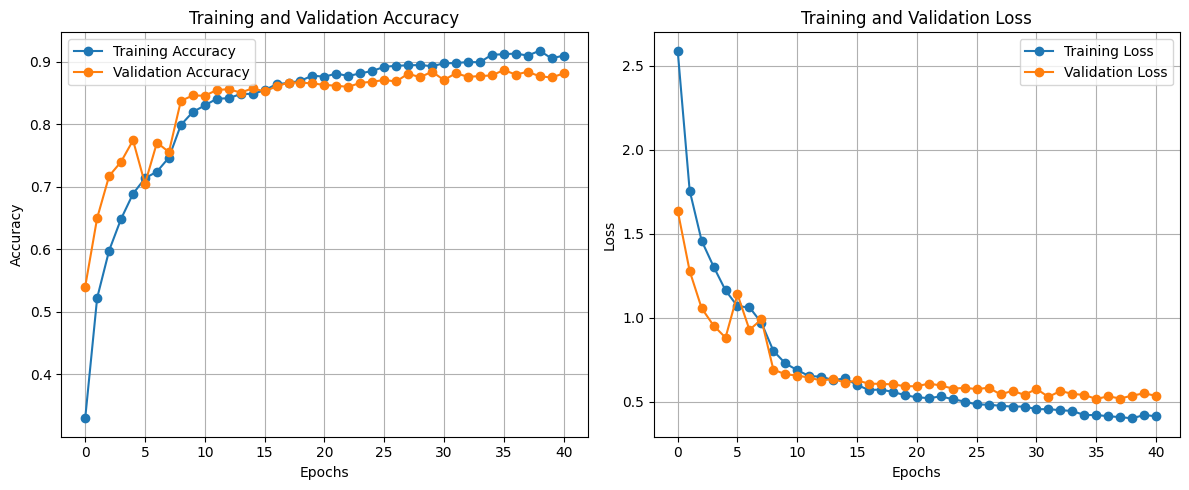

In [15]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc, precision_recall_fscore_support

y_true = test_generator.classes  
y_pred_probs = model.predict(test_generator)   
y_pred = np.argmax(y_pred_probs, axis=1) 

324/324 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step


In [28]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


In [29]:
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

     n000059       0.98      0.95      0.97       108
     n000070       0.96      0.99      0.98       122
     n000083       0.99      0.91      0.95       198
     n000425       0.80      0.96      0.87       120
     n000462       0.78      0.95      0.86       120
     n000463       0.96      0.75      0.84       132
     n000464       0.94      0.97      0.96       132
     n000465       0.84      0.91      0.87       120
     n000466       0.97      0.99      0.98       132
     n000467       0.96      0.97      0.96       132
     n000468       0.99      0.99      0.99        96
     n000469       0.98      0.99      0.98       132
     n000471       0.98      0.99      0.98       132
     n000472       0.85      0.92      0.88       156
     n000473       0.92      0.87      0.89       120
     n000474       0.88      0.94      0.91        96
     n000475       0.91      0.87      0.89       132
   

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
# Initialize ImageDataGenerator with the same preprocessing
datagen = ImageDataGenerator(rescale=1./255)  # Normalizing by 1./255

img = image.load_img('/kaggle/input/img-496/0095_01.jpg', target_size=(299, 299))  # Replace with your image path

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = datagen.standardize(img_array) 

In [26]:
# Predict using the model
predictions = model.predict(img_array)

# Get the class with the highest probability (for classification)
pred = train_generator.class_indices
pred = np.argmax(predictions, axis=-1)

# If it's a classification model, print the predicted class
print(f"Predicted Class: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted Class: [34]


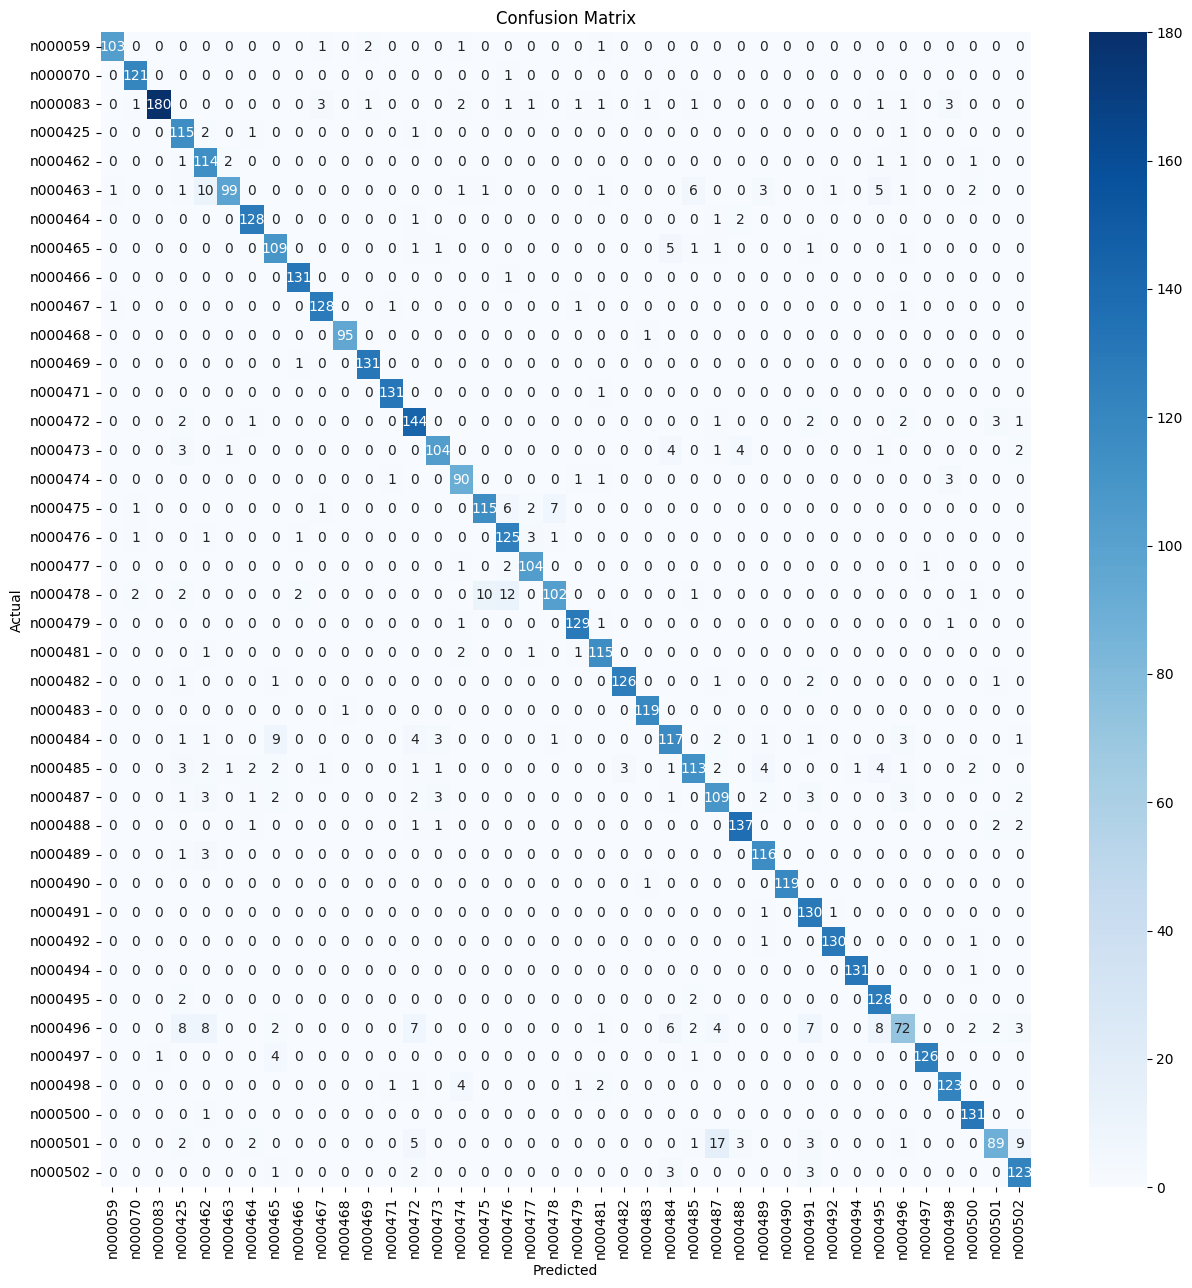

In [34]:
# فرضا أنك تستخدم بيانات الاختبار
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())  # استخدم test_generator بدلا من train_generator
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [32]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="weighted")
print(f"Weighted Multi-class ROC-AUC: {roc_auc:.2f}")

Weighted Multi-class ROC-AUC: 1.00


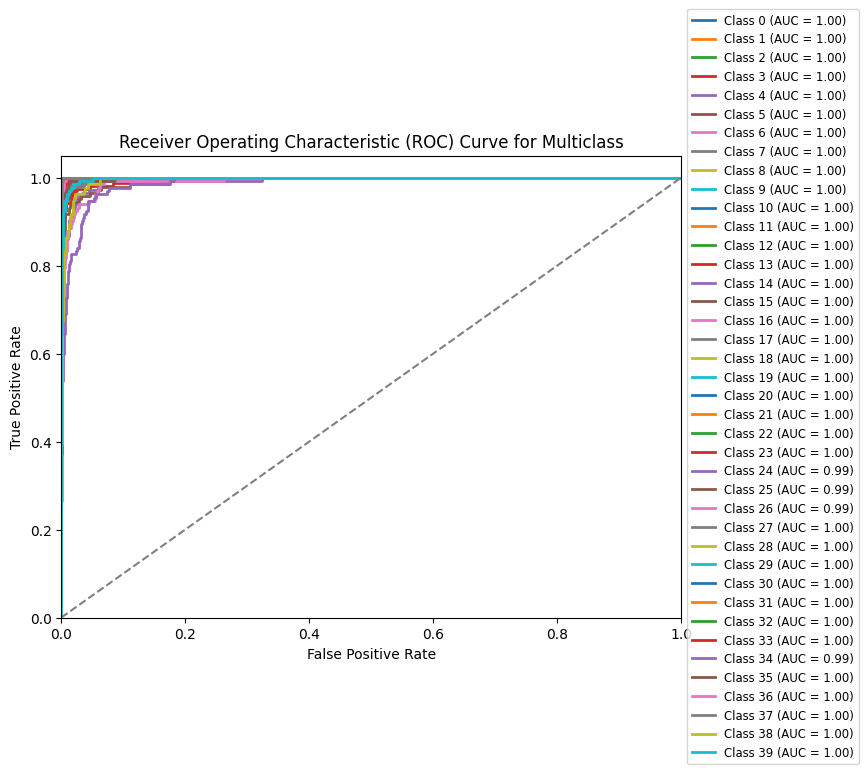

In [33]:
from sklearn.preprocessing import label_binarize
num_classes = y_pred_probs.shape[1]  # عدد الفئات
y_true_bin = label_binarize(y_true, classes=range(num_classes))  # تحويل إلى 1-hot encoding

# رسم منحنى ROC لكل فئة
plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # حساب منحنى ROC للفئة الحالية
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    
    # حساب AUC للفئة الحالية
    roc_auc = auc(fpr, tpr)
    
    # رسم منحنى ROC
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# إضافة الخط البياني العشوائي
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# إعدادات الرسم
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.show()